In [1]:
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import h5netcdf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import NaturalEarthFeature
from matplotlib import colors
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

# Investigation into individual countries time series - for domestic and industrial water withdrawals
The continuity of a time series is important because it ensures that the data accurately represents the underlying phenomenon/process being measured or observed (in our case, the grid/country/global population or gdp).
A lack of continuity can introduce biases, distortions, or inaccuracies in the analysis and interpretation of the data.



## Load the raw data and define the objects which will support the analysis:

In [2]:
# Load the pop data from 1861 till 2100
#hist_data = xr.open_dataset("../data/population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4", engine='h5netcdf', decode_times=False).pop[:,:,:]

In [3]:
# Load postprocessed water scarcity files (only postprocessing is merging and giving right time dimension)

waterscarcity_dir = '/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/waterscarcity_isimip/'

hist_data_domww = xr.open_dataset(waterscarcity_dir+'/data/2b/intermediate/lpjml/domww.nc')['domww']
hist_data_indww = xr.open_dataset(waterscarcity_dir+'/data/2b/intermediate/lpjml/indww.nc')['indww']

In [4]:
# Define the regions over which future masking will be applied
# In our case we are interested in country level aggregation
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries.plot(add_label=False)

<GeoAxesSubplot:>

In [5]:
# Generate a mask object for each country based on the grid of our input data
# This will result in an object that for a given country will have all corresponding gridcells filled with the country index value
# For example for US all corresponding gridcells will be filled with "4"
# All gridcells which are not part of any country will be filled with NaN
mask = countries.mask(hist_data_domww[0,:,:]).fillna(177) # we fillna values with a custom key "177" because some of these points, not identified as countries due to limits of regionmask package, actually contain some population (e.g., an insular country or not attributed coastline gridcells) and using this key we can still have access to these points

# Obtain a list of all countries names and index:
countries_names = countries.names
countries_index = countries.numbers

# Create a fictive country which would contain all the 177 masked gridcells
countries_names.append("Not a regionmask country")
countries_index.append(177)

## Compute individual countries time series and plot these time series:

In [9]:
# Initialize a zero array with countries and time dimensions
country_pop_timeseries = xr.DataArray(np.zeros((178, 240)), dims=('country', 'time'), 
                                      coords={'country': countries_index, 'time': range(1861, 2101)})

# Loop over years:
for year in range(1861, 2101):
    # Loop over each countries:
    for country in range(len(countries_index)):
        # Calculate country total population for given year
        country_pop_timeseries[country, year-1861] = np.nansum(hist_data[year-1861].where(mask == country))
    
    if year%20 == 0:
        print("Year completed: " + str(year))

Year completed: 1880
Year completed: 1900
Year completed: 1920
Year completed: 1940
Year completed: 1960
Year completed: 1980
Year completed: 2000
Year completed: 2020
Year completed: 2040
Year completed: 2060
Year completed: 2080
Year completed: 2100


In [ ]:
# Assuming time series starts from 1861 and ends in 2100
years = pd.date_range(start='1861', periods=240, freq='Y').year

# Iterate over each country and its population time series
for i, country in enumerate(countries_names):
    pop_timeseries_original = country_pop_timeseries[i]  # Original data, no changes
    
    # Creating a DataFrame for easy manipulation
    df = pd.DataFrame({'Year': years, 'Population_original': pop_timeseries_original})
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Population_original'], 'ro', markersize=3)
    plt.axvline(x=2000, color='blue', linestyle='--')  # This line adds a vertical line at the year 2005

    plt.axvline(x=2005, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.axvline(x=2010, color='green', linestyle='--')  # This line adds a vertical line at the year 2010
    plt.title(country)
    plt.xlabel('Year')
    plt.ylabel('Domestic water withdrawal')
    
    # Save to pdf
    pdf_path = f"../withdrawals/{country}_original_domww_time_series_1861_2100.pdf"
    plt.savefig(pdf_path, format='pdf')
    plt.close()

# Spatial consistency of the dataset:
Since we are now sure that national time series are correct for each country, we also need to check how this national population is distributed across gridcells.
For example, Inne Valderkelen identified that there is a spatial inconsistency at the transition year 2005-2006, between the historic and ssp2 dataset.
The spatial inconsistency consist in the fact, that some gridcell time series experience a sudden drop or jump at the transition year (e.g. from 0 to 100000 people in one year).
This is an unrealistic behavior, making it impossible to use for analysis on gridcell level, and putting under question model results which were generated using this data.

While a solution was already proposed for this specific issue, it is worth looking if there are no similar issues for the remaining of years.
Also, to be more precise in our assessment of the spatial consistency, we will analyze this property at country level instead of global.

To do this, we need an objective metric to estimate the spatial consistency between each consecutive years.
For this scope, we propose the following metric:

metric_spatial_consistency_for_given_country_and_transition_year(N-1) =  Sum_over_all_grids[absolute_value(gridded_country_pop_year(N) - gridded_country_pop_year(N-1))]/[absolute_value(aggregated_country_pop_year(N) - aggregated_country_pop_year(N-1))] 

Normally, we can expect the following behavior from this metric:
1) If the weights of each gridcell for a given country, remain the same at the transition between the year N and N-1, then this metric will return 1. 
2) If the weights are changing, it means, that at the transition between year N and N-1, some grids gain population weight relatively to others in the same country. In this case the metric will return a value larger than 1. 

It should be mentioned that in practice, it is ok to have this metric > 1. Actually in reality, most of the time this will be the case, as human settlements in a given country can grow at different rates, which gradually is changing the grids weights with some places cumulating population faster or slower.

At the same time, if we observe an anomaly in this metric, with a sudden change significantly exceeding the normal statistics, it is likely due to a problem with the data.

In [7]:
# replace corrected data with original data as correction is not done! 

hist_data_with_corrected_national_time_series = hist_data_domww.copy(deep=True)
corrected_data_for_given_year = hist_data_with_corrected_national_time_series[:, :, :].copy(deep=True)


In [40]:
# Initialize a zero array with countries and time dimensions
metric_spatial_consistency_for_given_country_and_transition_year = xr.DataArray(np.zeros((178, 239)), dims=('country', 'time'), 
                                                                  coords={'country': countries_index, 'time': range(1861, 2100)})

# Loop over years:
for year in range(1861, 2098):
    # Loop over each countries:
    for country in range(len(countries_index)):
        # Calculate country total population for given year
        metric_spatial_consistency_for_given_country_and_transition_year[country, year-1861] = np.nansum(np.abs(corrected_data_for_given_year[year-1861+1].where(mask==country) - corrected_data_for_given_year[year-1861].where(mask==country)))/(np.abs(np.nansum(corrected_data_for_given_year[year-1861+1].where(mask==country)) - np.nansum(corrected_data_for_given_year[year-1861].where(mask==country))))

    if year%20==0:
        print("Year completed: " + str(year))

Year completed: 1880
Year completed: 1900
Year completed: 1920
Year completed: 1940
Year completed: 1960
Year completed: 1980
Year completed: 2000
Year completed: 2020
Year completed: 2040
Year completed: 2060
Year completed: 2080


In [10]:
# Assuming time series starts from 1861 and ends in 2100
years = pd.date_range(start='1861', periods=239, freq='Y').year

# Iterate over each country and its population time series
for i, country in enumerate(countries_names):
    country_spatial_consistency = metric_spatial_consistency_for_given_country_and_transition_year[i] 
    
    # Creating a DataFrame for easy manipulation
    df = pd.DataFrame({'Year': years, 'Country_spatial_consistency': country_spatial_consistency})
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Country_spatial_consistency'], 'k-', markersize=3)
    plt.axvline(x=2005, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.axvline(x=2010, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.title(country)
    plt.xlabel('Year')
    plt.ylabel('Spatial Consistency Metric')
    
    # Save to pdf
    # pdf_path = f"../results/country_level_spatial_consistency/{country}_spatial_consistency_metric_1861_2100.pdf"
    pdf_path = f"../results/withdrawals/{country}_spatial_consistency_metric_1861_2100.pdf"

    plt.savefig(pdf_path, format='pdf')
    
    plt.close()

# Understand normal vs spatial inconsistent behavior
As we mentioned, it is normal that sometimes the metric we compute exceeds 1.0.
This can correspond to a situation where population in some grids is changing faster than the others for the same country.

At the same time, we know that the years 2005-2010 are anomalous for the dataset, as spacial inconsistency is introduced through merging the historic and ssp data. Therefore, we can try to use this period to understand what an abnormal value for our metric is.

By collecting the statistics over the period 1861-2004 and 2005-2010 for all countries for our spatial inconsistency metric, we can build density functions. By comparing the two density functions, we can then understand what is the likely threshold over which, maybe, there is a spatial inconsistency situation.

We can see that the period from 2011-2100, while mostly spatially consistent, there are some signs of spatial consistency anomalies.
This can also be confirmed by looking at the individual countries time series of the spatial consistency metrics (computed and saved in the previous step). 
In some sense, this raises the question of why this is happening (the assumptions behind the scenario data creation) and to what extent we can trust the robustness and continuity of individual gridcell time series.

In [17]:
%matplotlib inline

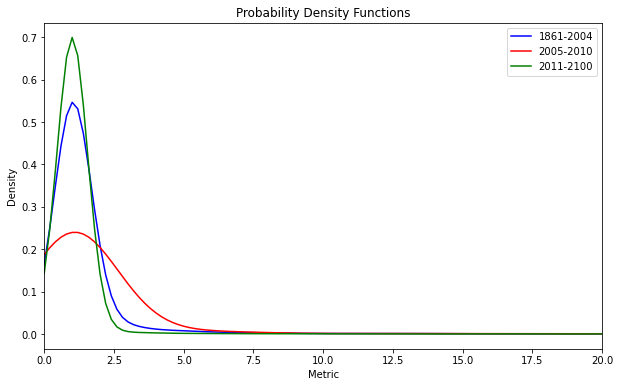

In [18]:
from scipy.stats import gaussian_kde

# assuming the xarray DataArray is already loaded as metric_spatial_consistency_for_given_country_and_transition_year

# Subset the data for the three periods
period1_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(1861,2004))
period2_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(2005,2010))
period3_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(2011,2100))

# Reshape data to 1D array for the KDE function
period1_data_1d = period1_data.values.flatten()
period2_data_1d = period2_data.values.flatten()
period3_data_1d = period3_data.values.flatten()

# Remove NaN and Inf values
period1_data_1d = period1_data_1d[~np.isnan(period1_data_1d) & ~np.isinf(period1_data_1d)]
period2_data_1d = period2_data_1d[~np.isnan(period2_data_1d) & ~np.isinf(period2_data_1d)]
period3_data_1d = period3_data_1d[~np.isnan(period3_data_1d) & ~np.isinf(period3_data_1d)]

# Replace values larger than 100 with 100
period1_data_1d = np.where(period1_data_1d > 100, 100, period1_data_1d)
period2_data_1d = np.where(period2_data_1d > 100, 100, period2_data_1d)
period3_data_1d = np.where(period3_data_1d > 100, 100, period3_data_1d)

# Generate kernel density estimates for the three periods
kde1 = gaussian_kde(period1_data_1d)
kde2 = gaussian_kde(period2_data_1d)
kde3 = gaussian_kde(period3_data_1d)

# Define a range for the x-axis (you might want to adjust this based on your data)
x_range = np.linspace(min(min(period1_data_1d), min(period2_data_1d), min(period3_data_1d)), max(max(period1_data_1d), max(period2_data_1d), max(period3_data_1d)), 500)

# Evaluate the KDE functions on the x_range
kde1_eval = kde1.evaluate(x_range)
kde2_eval = kde2.evaluate(x_range)
kde3_eval = kde3.evaluate(x_range)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde1_eval, label='1861-2004', color='blue')
plt.plot(x_range, kde2_eval, label='2005-2010', color='red')
plt.plot(x_range, kde3_eval, label='2011-2100', color='green')
plt.title('Probability Density Functions')
plt.xlabel('Metric')
plt.ylabel('Density')
plt.xlim([0,20])
plt.legend()
plt.show()


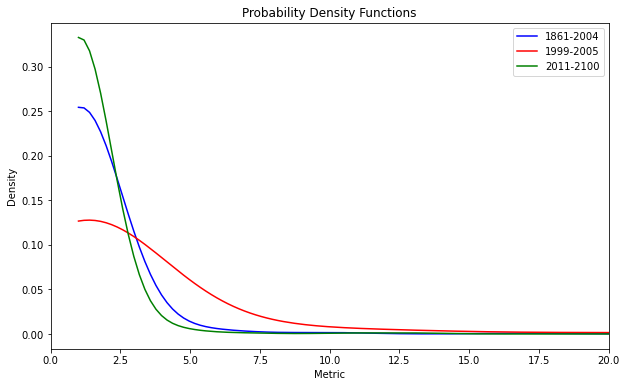

In [39]:
from scipy.stats import gaussian_kde

# assuming the xarray DataArray is already loaded as metric_spatial_consistency_for_given_country_and_transition_year

# Subset the data for the three periods
period1_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(1998,1999))
period2_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(1999,2000))
period3_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(2006,2007))

# Reshape data to 1D array for the KDE function
period1_data_1d = period1_data.values.flatten()
period2_data_1d = period2_data.values.flatten()
period3_data_1d = period3_data.values.flatten()

# Remove NaN and Inf values
period1_data_1d = period1_data_1d[~np.isnan(period1_data_1d) & ~np.isinf(period1_data_1d)]
period2_data_1d = period2_data_1d[~np.isnan(period2_data_1d) & ~np.isinf(period2_data_1d)]
period3_data_1d = period3_data_1d[~np.isnan(period3_data_1d) & ~np.isinf(period3_data_1d)]

# Replace values larger than 100 with 100
period1_data_1d = np.where(period1_data_1d > 100, 100, period1_data_1d)
period2_data_1d = np.where(period2_data_1d > 100, 100, period2_data_1d)
period3_data_1d = np.where(period3_data_1d > 100, 100, period3_data_1d)

# Generate kernel density estimates for the three periods
kde1 = gaussian_kde(period1_data_1d)
kde2 = gaussian_kde(period2_data_1d)
kde3 = gaussian_kde(period3_data_1d)

# Define a range for the x-axis (you might want to adjust this based on your data)
x_range = np.linspace(min(min(period1_data_1d), min(period2_data_1d), min(period3_data_1d)), max(max(period1_data_1d), max(period2_data_1d), max(period3_data_1d)), 500)

# Evaluate the KDE functions on the x_range
kde1_eval = kde1.evaluate(x_range)
kde2_eval = kde2.evaluate(x_range)
kde3_eval = kde3.evaluate(x_range)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde1_eval, label='1861-2004', color='blue')
plt.plot(x_range, kde2_eval, label='1999-2005', color='red')
plt.plot(x_range, kde3_eval, label='2011-2100', color='green')
plt.title('Probability Density Functions')
plt.xlabel('Metric')
plt.ylabel('Density')
plt.xlim([0,20])
plt.legend()
plt.show()


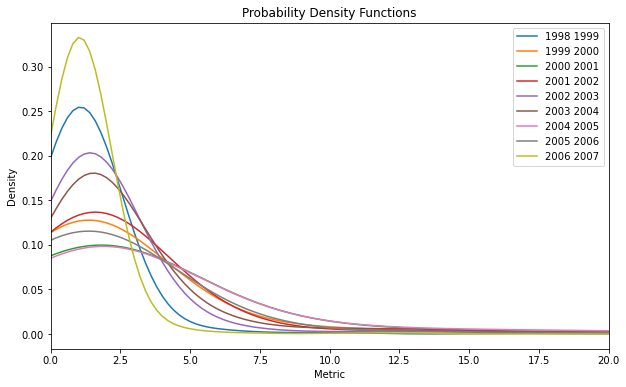

In [30]:
from scipy.stats import gaussian_kde

# assuming the xarray DataArray is already loaded as metric_spatial_consistency_for_given_country_and_transition_year
# Generate the plot
plt.figure(figsize=(10, 6))

for year in range(1998,2007): 


    # Subset the data for the three periods
    period1_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(year,year+1))

    # Reshape data to 1D array for the KDE function
    period1_data_1d = period1_data.values.flatten()


    # Remove NaN and Inf values
    period1_data_1d = period1_data_1d[~np.isnan(period1_data_1d) & ~np.isinf(period1_data_1d)]

    # Replace values larger than 100 with 100
    period1_data_1d = np.where(period1_data_1d > 100, 100, period1_data_1d)

    # Generate kernel density estimates for the three periods
    kde1 = gaussian_kde(period1_data_1d)


    # Define a range for the x-axis (you might want to adjust this based on your data)
    x_range = np.linspace(min(min(period1_data_1d), min(period2_data_1d), min(period3_data_1d)), max(max(period1_data_1d), max(period2_data_1d), max(period3_data_1d)), 500)

    # Evaluate the KDE functions on the x_range
    kde1_eval = kde1.evaluate(x_range)



    plt.plot(x_range, kde1_eval, label=str(year)+' '+str(year+1))

plt.title('Probability Density Functions')
plt.xlabel('Metric')
plt.ylabel('Density')
plt.xlim([0,20])
plt.legend()
plt.show()


# What is the threshold?
A good estimate can be the moment when kde2_eval > kde1_eval

In [16]:
threshold_spatial_inconsistency = x_range[kde2_eval > kde1_eval][0]
print(threshold_spatial_inconsistency)

4.208416833667335
